# Hybrid Model 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-04-18 05:37:35.626916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 05:37:35.627023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 05:37:35.751871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import librosa
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Input, Masking, Dense, Dropout, Concatenate, Flatten, Bidirectional

In [3]:
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
df = pd.read_csv('/kaggle/input/iemocap-dataset/dataset_final.csv')

In [6]:
df = df[:3000]

In [13]:
df

,id,audio_file,text,class,label,spectrogram_file
0,Ses02M_script01_1_M026,/kaggle/input/iemocap-dataset/Session2_useful/...,I wanted to get this settled first.,neutral,5,/kaggle/input/iemocap-dataset/Session2_useful/...
1,Ses03M_script01_2_M008,/kaggle/input/iemocap-dataset/Session3_useful/...,How do you know why she's waited? Hmmm?,neutral,5,/kaggle/input/iemocap-dataset/Session3_useful/...
2,Ses01F_script01_1_F040,/kaggle/input/iemocap-dataset/Session1_useful/...,Well you don't want to think like that.,anger,2,/kaggle/input/iemocap-dataset/Session1_useful/...
3,Ses03F_impro07_F029,/kaggle/input/iemocap-dataset/Session3_useful/...,Yeah. Those little-- --mattresses. I'll put it...,joy,1,/kaggle/input/iemocap-dataset/Session3_useful/...
4,Ses01M_script02_2_M026,/kaggle/input/iemocap-dataset/Session1_useful/...,Do you want to dance?,joy,1,/kaggle/input/iemocap-dataset/Session1_useful/...
...,...,...,...,...,...,...
2995,Ses03M_impro03_M019,/kaggle/input/iemocap-dataset/Session3_useful/...,Yeah.,neutral,5,/kaggle/input/iemocap-dataset/Session3_useful/...
2996,Ses01M_script01_3_F028,/kaggle/input/iemocap-dataset/Session1_useful/...,Everything Chris do you understand that? To m...,anger,2,/kaggle/input/iemocap-dataset/Session1_useful/...
2997,Ses01M_script01_1_M041,/kaggle/input/iemocap-dataset/Session1_useful/...,I am thinking like that.,anger,2,/kaggle/input/iemocap-dataset/Session1_useful/...
2998,Ses01M_impro02_M013,/kaggle/input/iemocap-dataset/Session1_useful/...,I guess you're just going to have to have it w...,sad,0,/kaggle/input/iemocap-dataset/Session1_useful/...


In [14]:
df.label.value_counts()

label
5    1531
2     538
0     438
1     385
4      81
3      27
Name: count, dtype: int64

### Getting audio input ready 

In [15]:
y, sr = librosa.load(df.audio_file[0])
rms = np.array(librosa.feature.rms(y=y))
rms.shape

(1, 103)

In [16]:
def get_time_stamps(filepath):
    y, sr = librosa.load(filepath)
    rms = np.array(librosa.feature.rms(y=y))
    return rms.shape[1]

get_time_stamps(df.audio_file[0])

103

In [17]:
df['timesteps'] = df.audio_file.progress_apply(get_time_stamps)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [18]:
df.timesteps.describe()

count    3000.000000
mean      185.094667
std       129.028864
min        29.000000
25%        97.000000
50%       146.000000
75%       236.000000
max      1255.000000
Name: timesteps, dtype: float64

(array([ 16.,  68., 139., 192., 207., 225., 172., 222., 178., 157., 133.,
        125., 112.,  90.,  85.,  79.,  59.,  64.,  59.,  62.,  64.,  47.,
         38.,  53.,  21.,  31.,  30.,  23.,  23.,  17.,  18.,  20.,  17.,
         14.,  17.,  10.,   6.,   6.,   9.,  14.,   7.,   4.,   9.,   4.,
          3.,   4.,   4.,   5.,   1.,   2.,   6.,   2.,   3.,   1.,   1.,
          2.,   3.,   0.,   2.,   1.,   2.,   1.,   1.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  29.  ,   41.26,   53.52,   65.78,   78.04,   90.3 ,  102.56,
         114.82,  127.08,  139.34,  151.6 ,  163.86,  176.12,  188.38,
         200.64,  212.9 ,  225.16,  237.42,  249.68,  261.94,  274.2 ,
         286.46,  298.72,  310.98,  323.24,  335.5 ,  347.76,  360.02,
         372.28,  384.54,  396.8 ,

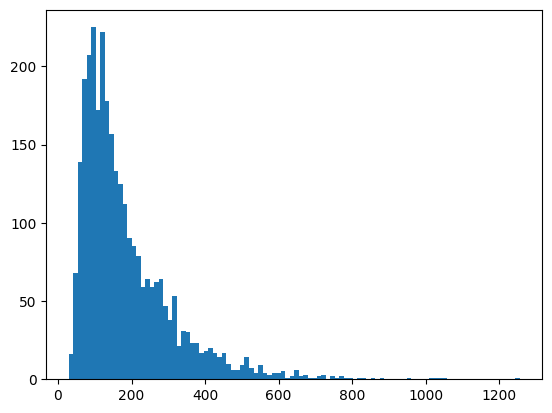

In [19]:
plt.hist(df.timesteps.tolist(), bins=100)

In [20]:
def extract_all_features(filename):
    y, sr = librosa.load(filename)
    chroma_stft = np.array(librosa.feature.chroma_stft(y=y, sr=sr)).T
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr)).T
    rms = np.array(librosa.feature.rms(y=y)).T
    spectral_contrast = np.array(librosa.feature.spectral_contrast(y=y, sr=sr)).T

    all_features = np.hstack((chroma_stft, mfcc, rms, spectral_contrast))
    return all_features

In [21]:
lst = []
audio_files = df.audio_file.tolist()

for i in tqdm(range(len(df))):
    filename = audio_files[i]
    lst.append(extract_all_features(filename))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
len(lst)

3000

#### Padding and truncation for LSTM

In [23]:
def add_padding(lst_ele, max_len):
    atmask = np.ones(lst_ele.shape)
    atmask_pad = np.zeros((max_len - lst_ele.shape[0], 40))
    pads = np.zeros((max_len - lst_ele.shape[0], 40))

    return np.vstack((lst_ele, pads)), np.vstack((atmask, atmask_pad))

In [24]:
X = []
Attentions = []
max_length = 500

for i in tqdm(range(len(lst))):
    tstamps = lst[i].shape[0]
    if tstamps < max_length:
        ele, atmask = add_padding(lst[i], max_length)
    elif tstamps >= max_length:
        ele = lst[i][:max_length]
        atmask = np.ones((max_length, 40))

    X.append(ele)
    Attentions.append(atmask)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [25]:
X = np.array(X)
X.shape

(3000, 500, 40)

In [26]:
y = df.label.to_numpy()
y.shape

(3000,)

In [27]:
from tensorflow.keras.utils import to_categorical

y_one_hot = to_categorical(y, num_classes=6)

In [28]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)

In [29]:
print(X_train.shape, y_train.shape)
print(X_val.shape)
print(X_test.shape)

(2400, 500, 40) (2400, 6)
(300, 500, 40)
(300, 500, 40)


In [30]:
feature_dim = 40
optimizer = 'adam'
loss = 'categorical_crossentropy'
batch_size = 16
epochs = 10

### Getting image input ready

In [33]:
def load_images(file_paths, target_size=(299, 299)):
    images = []
    for file_path in tqdm(file_paths):
        img = Image.open(file_path)
        img = img.convert('RGB')
        # Resize the image
        img = img.resize(target_size)
        # Convert image to numpy array
        img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    return np.array(images)

In [34]:
X_images = load_images(df.spectrogram_file.tolist())

  0%|          | 0/3000 [00:00<?, ?it/s]

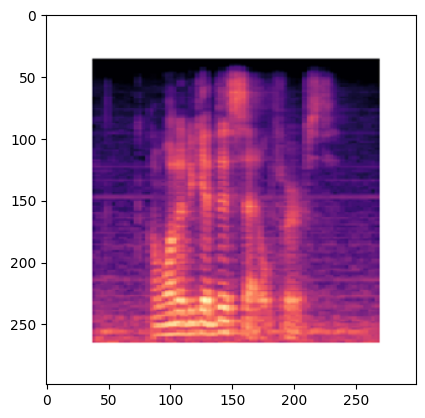

In [35]:
plt.imshow(X_images[0])

In [37]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import VGG16

### Hybrid model building

In [39]:
X_train[0].shape

(500, 40)

In [40]:
X_images[0].shape

(299, 299, 3)

In [41]:
audio_input_shape = (X_train[0].shape) 
image_input_shape = (X_images[0].shape)

In [42]:
image_input_shape

(299, 299, 3)

In [43]:
audio_input_shape

(500, 40)

In [44]:
audio_input = Input(shape=audio_input_shape, name='audio_input')
image_input = Input(shape=image_input_shape, name='image_input')

### LSTM


In [47]:
from keras.layers import Bidirectional, LSTM, Dense, Masking, GlobalMaxPooling1D, Dot, Concatenate

In [48]:
input_layer = Input(shape=(500, 40))


In [49]:
max_length = 500
feature_dim = 40

masked_input = Masking(mask_value=0.)(audio_input) 

lstm_layer1 = LSTM(64, return_sequences=True)(masked_input)
lstm_layer2 = LSTM(64, return_sequences=False)(lstm_layer1) 
linear_layer = Dense(512, activation='relu')(lstm_layer2)
output_emb = Dense(128, activation='softmax')(linear_layer)

In [50]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=image_input_shape)
# Add custom layers on top of ResNet50
resnet_output = GlobalAveragePooling2D()(vgg_model(image_input))
x = Dense(512, activation='relu')(resnet_output)
image_emb = Dense(128, activation='tanh')(x)

# Freeze the base model
for layer in vgg_model.layers[:-4]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [51]:
concatenated_output = tf.keras.layers.concatenate([output_emb, image_emb])

In [52]:
dense_layer = Dense(128, activation='relu')(concatenated_output)
dense_layer2 = Dense(64, activation='relu')(dense_layer)
output_layer = Dense(6, activation='softmax')(dense_layer2)

In [53]:
hybrid_model = Model(inputs=[audio_input, image_input], outputs=output_layer)

In [54]:
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
hybrid_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 500, 40)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 500, 40)   │          0 │ audio_input[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 500, 40)   │          0 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 500)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 500, 64)   │     26,880 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 9, 9, 512) │ 14,714,688 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lstm[0][0],       │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     33,280 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     65,664 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 6)         │        390 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,243,398 (58.15 MB)

 Trainable params: 15,243,398 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

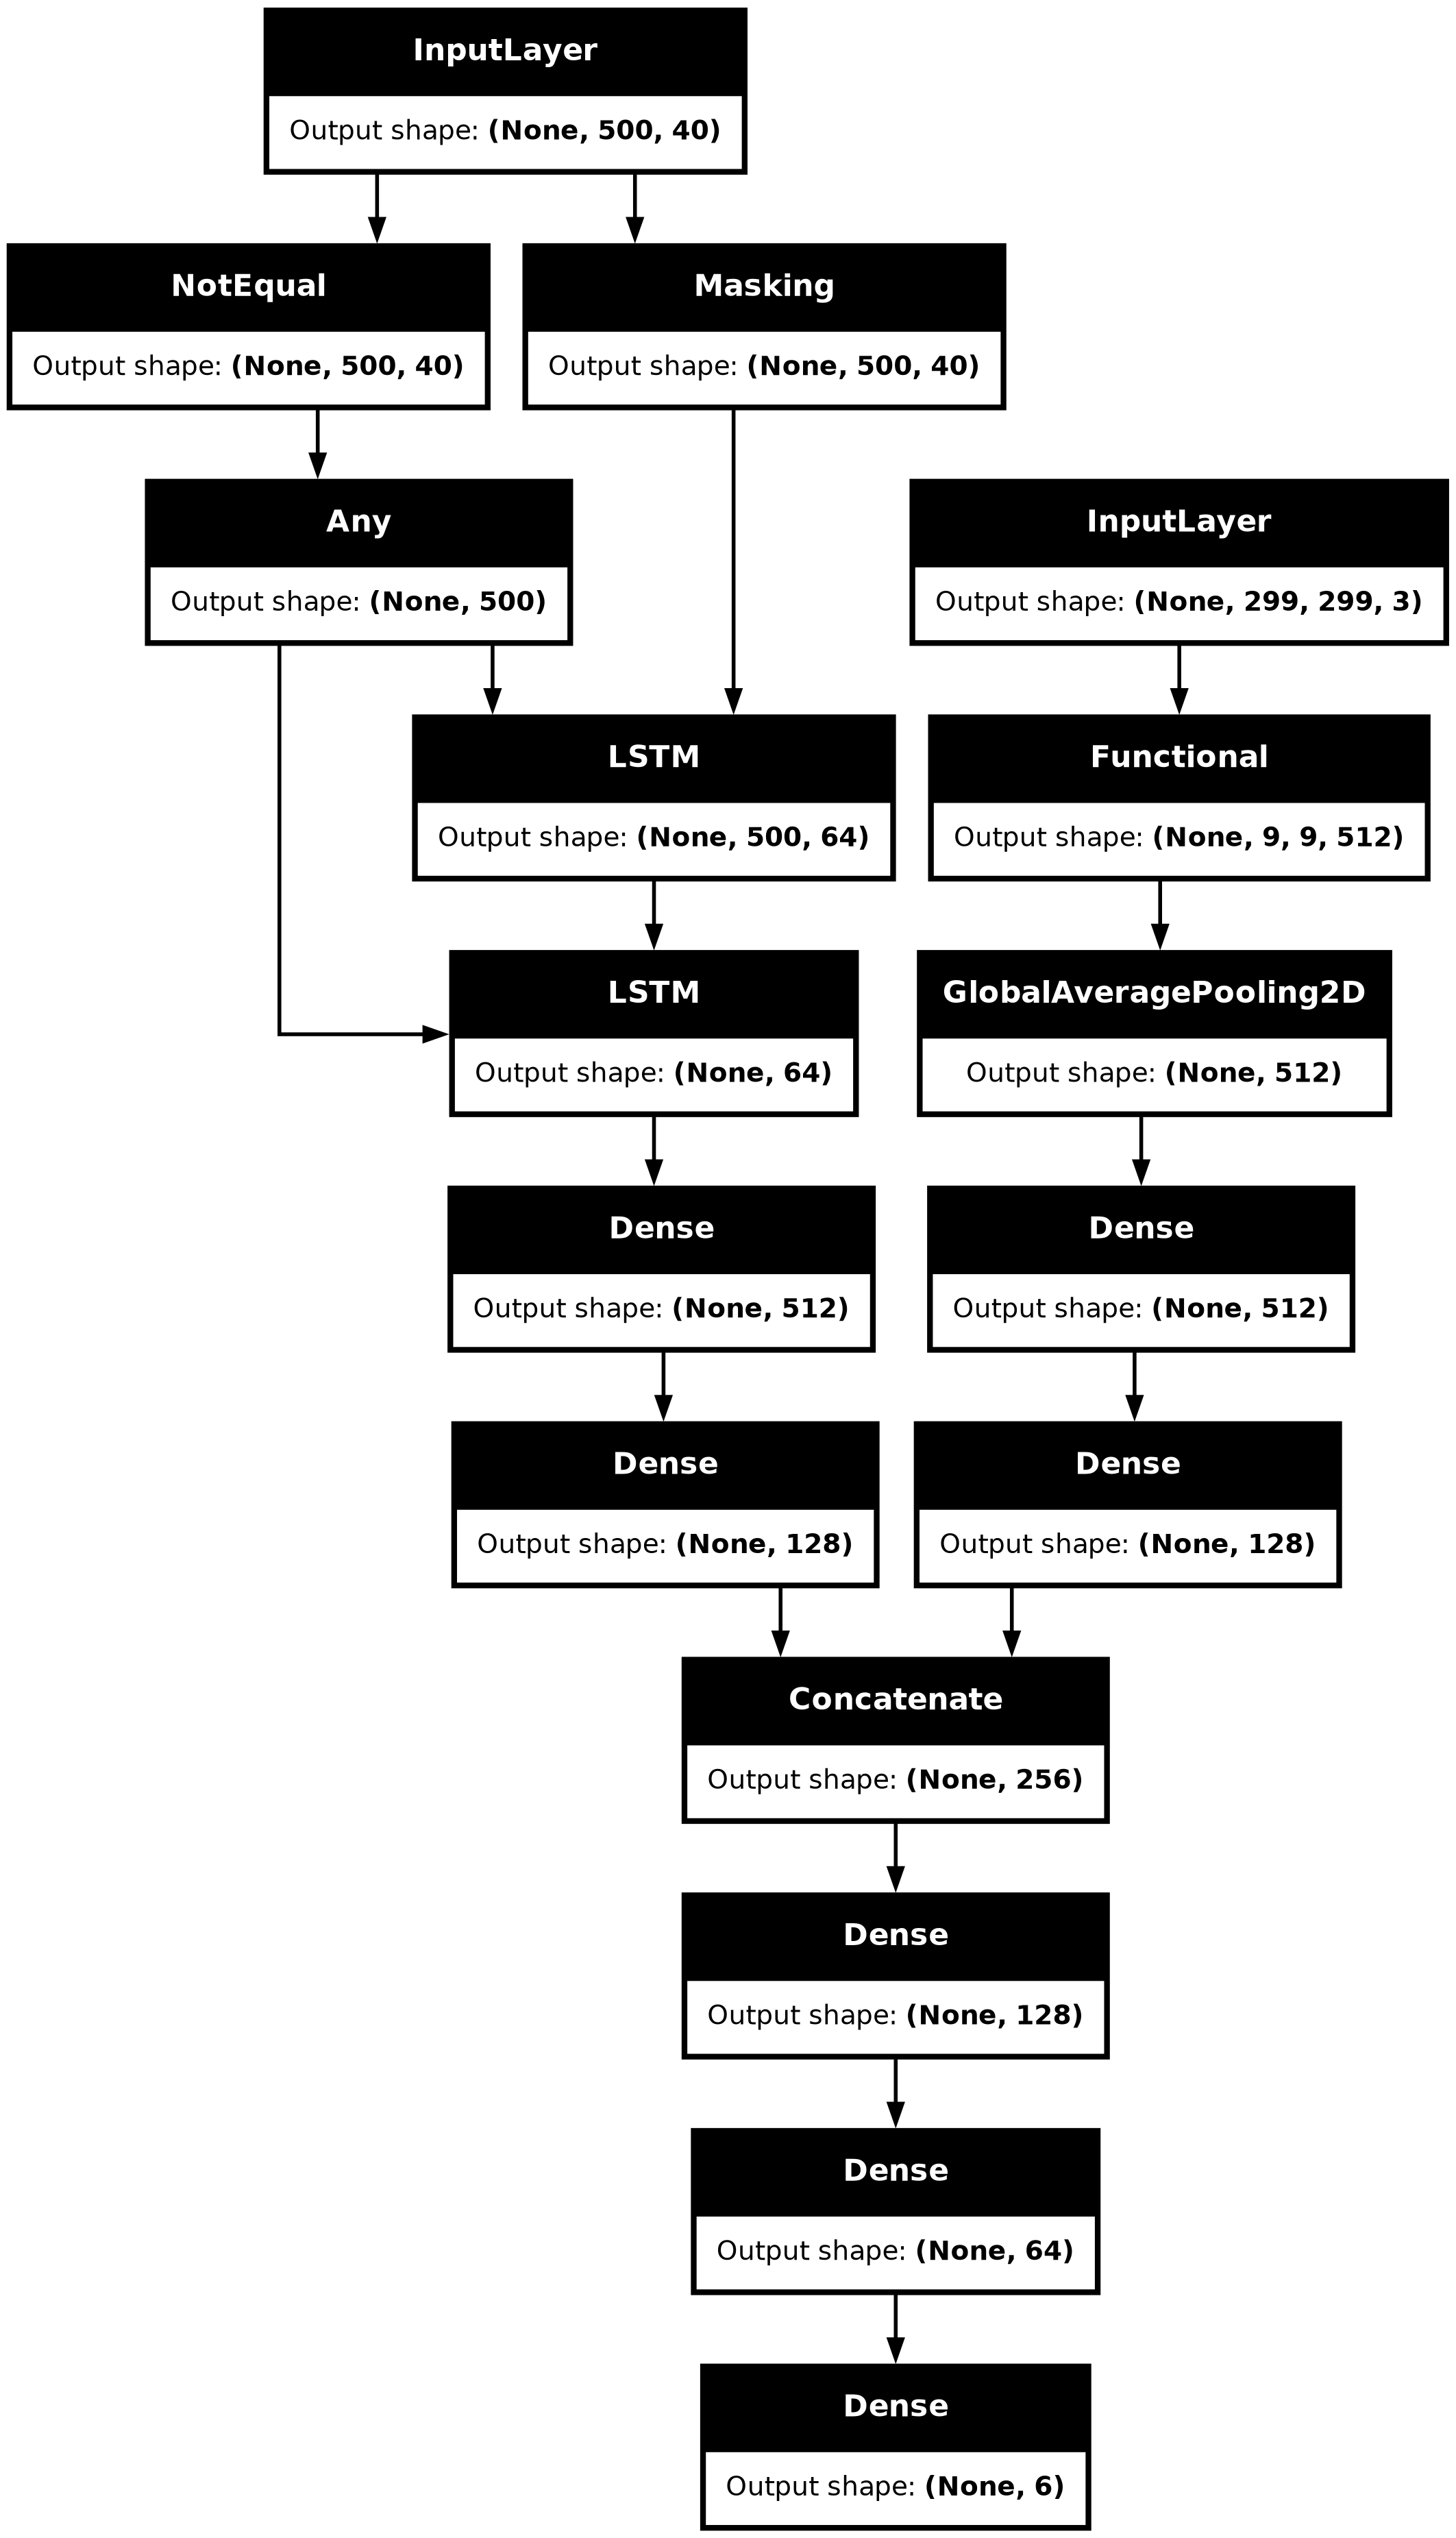

In [56]:
from tensorflow.keras.utils import plot_model

plot_model(hybrid_model, to_file='image.png', show_shapes = True)

In [57]:
# from keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = hybrid_model.fit(
    x={'audio_input': X[:2500], 'image_input': X_images[:2500]},
    y=y_one_hot[:2500],
    epochs=10,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4746 - loss: 1.4164 - val_accuracy: 0.5180 - val_loss: 1.3182
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.4878 - loss: 1.3714 - val_accuracy: 0.5180 - val_loss: 1.3047
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.5187 - loss: 1.3178 - val_accuracy: 0.5360 - val_loss: 1.2884
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5023 - loss: 1.3057 - val_accuracy: 0.5500 - val_loss: 1.2972
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5559 - loss: 1.2824 - val_accuracy: 0.5720 - val_loss: 1.2262
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5532 - loss: 1.2725 - val_accuracy: 0.5640 - val_loss: 1.2326
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5517 - loss: 1.2748 - val_accuracy: 0.5620 - val_loss: 1.1629
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5527 - loss: 1.2556 - val_accu

In [58]:
history

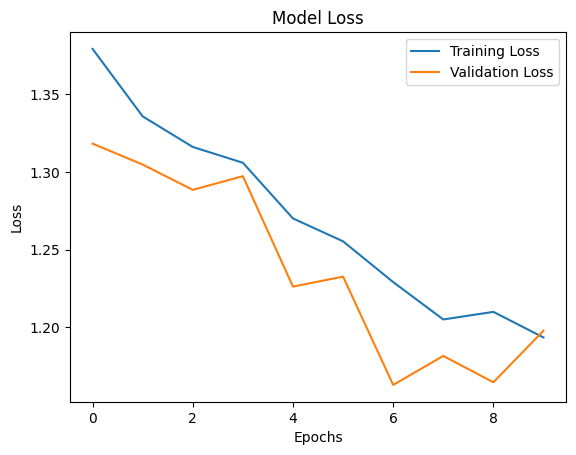

In [59]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
hybrid_model.save_weights('hybrid_6.weights.h5')

In [61]:
new_model = Model(inputs=[audio_input, image_input], outputs=output_layer)
new_model.load_weights('/kaggle/working/hybrid_6.weights.h5')

In [62]:
output = new_model.predict({'audio_input': X[2500:], 'image_input': X_images[2500:]})

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 920ms/step


In [ ]:
np.argmax(output, axis=1)

In [63]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

for i in range(len(output)):
    y_pred.append(np.argmax([output[i]], axis=1)[0])
    y_true.append(np.argmax([y_one_hot[2500 + i]], axis=1)[0])
    
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.00      0.00      0.00        74
           2       0.45      0.65      0.53        86
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.62      0.88      0.73       264

    accuracy                           0.58       500
   macro avg       0.18      0.26      0.21       500
weighted avg       0.41      0.58      0.48       500



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
